In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf  
yf.pdr_override()

In [2]:
now = datetime.now()

before = now - relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
befor_day = before.strftime("%Y-%m-%d")
print(f"end  : {now_day}")
print(f"start: {befor_day}")

samsung_stock = pdr.get_data_yahoo( "005930.KS", start=befor_day, end=now_day)
print(samsung_stock)

end  : 2021-12-07
start: 2011-12-07
[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2011-12-07  21000.0  21360.0  20820.0  21120.0  17197.039062  19746900
2011-12-08  21140.0  21660.0  20920.0  21280.0  17327.314453  25893000
2011-12-09  20980.0  21480.0  20740.0  21060.0  17148.179688  13804200
2011-12-12  21260.0  21680.0  21200.0  21680.0  17653.015625  12163550
2011-12-13  21480.0  21500.0  21000.0  21000.0  17099.316406  13210000
...             ...      ...      ...      ...           ...       ...
2021-11-30  73200.0  73900.0  70500.0  71300.0  71300.000000  30364841
2021-12-01  72000.0  74800.0  71600.0  74400.0  74400.000000  21954856
2021-12-02  73900.0  75800.0  73800.0  75800.0  75800.000000  23652940
2021-12-03  75600.0  76000.0  74100.0  75600.0  75600.000000  18330240
2021-12-06  75100.0  76700.0  74900.0  7630

In [3]:
close_prices = samsung_stock['Close'].values
print(close_prices)

windown_size = 30

result_list = []
for i in range(len(close_prices) - (windown_size + 1)):
    result_list.append(close_prices[i: i + (windown_size + 1)])

normal_data = []
for window in result_list:
    window_list = [((float(p) / float(window[0])) - 1) for p in window]
    normal_data.append(window_list)

result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])

[21120. 21280. 21060. ... 75800. 75600. 76300.]
2430 31


In [4]:
row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result_list[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result_list[row:, -1]

x_train.shape, x_test.shape

((2187, 30, 1), (243, 30, 1))

In [5]:
model = Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=10)

model.save(r'C:\파이썬과 40개의 작품들\39. 삼성전자의 주식 예측하기\samsung.h5')

Epoch 1/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0011 - val_loss: 4.9050e-04
Epoch 2/10
219/219 [==============================] - 2s 9ms/step - loss: 5.0290e-04 - val_loss: 3.2967e-04
Epoch 3/10
219/219 [==============================] - 2s 9ms/step - loss: 3.6915e-04 - val_loss: 2.4918e-04
Epoch 4/10
219/219 [==============================] - 2s 9ms/step - loss: 3.3758e-04 - val_loss: 2.6372e-04
Epoch 5/10
219/219 [==============================] - 2s 9ms/step - loss: 3.3320e-04 - val_loss: 2.5519e-04
Epoch 6/10
219/219 [==============================] - 2s 9ms/step - loss: 3.2877e-04 - val_loss: 2.5995e-04
Epoch 7/10
219/219 [==============================] - 2s 9ms/step - loss: 3.2974e-04 - val_loss: 2.7868e-04
Epoch 8/10
219/219 [==============================] - 2s 9ms/step - loss: 3.2619e-04 - val_loss: 3.1122e-04
Epoch 9/10
219/219 [==============================] - 2s 9ms/step - loss: 3.2204e-04 - val_loss: 3.5935e-04
Epoch 10/10
219/219 [==========

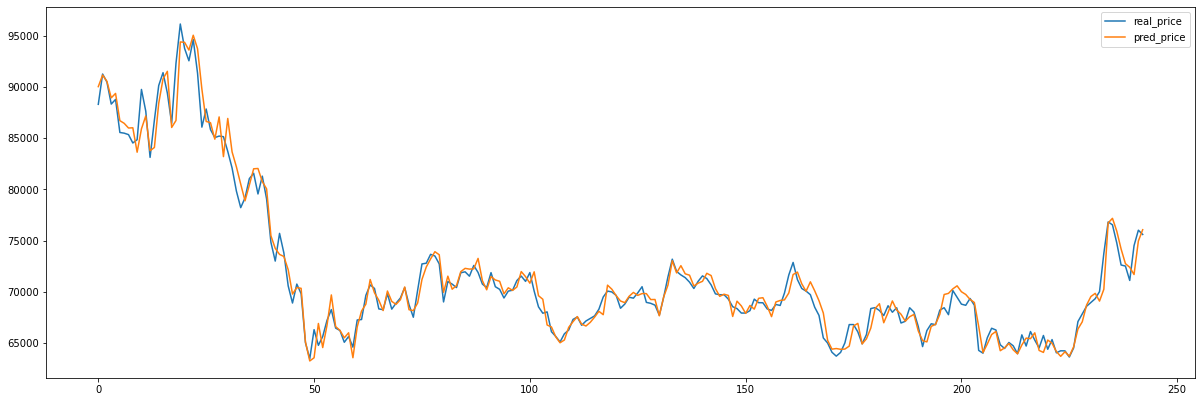

In [7]:
pred = model.predict(x_test)

pred_price = []
for i in pred:
    pred_price.append( (i + 1) * window[0] )
    
real_price = []
for i in y_test:
    real_price.append( (i + 1) * window[0] )

fig = plt.figure(facecolor='white', figsize=(70, 15))
ax = fig.add_subplot(234)
ax.plot(real_price, label='real_price')
ax.plot(pred_price, label='pred_price')
ax.legend()
plt.show()